In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import skimage

import os
import sys
from glob import glob

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

FIGOUTDIR = '../output/figures/image_analysis/'

In [3]:
! mkdir -p $FIGOUTDIR || true;

In [4]:
datasets = {
    'Cbx7Lap2b_H3K27me3': '20231003.2cell.Cbx7-Lap2b_Dam-Lmnb1.DAPI_FLAG_Tracer_H3K27me3',
    'Cbx7Lap2b_H3K9me3': '20231010_Cbx7_Lap2b_Dam-Lmnb1.DAPI_FLAG_Tracer_H3K9me3',
    'EEDmKO_H3K27me3': '20231024.2cell.EEDmKO.DAPI_H3K27me3',
    'EEDmKO_H3K9me3': '20231024.2cell.EEDmKO.DAPI_H3K9me3'
}

## 1.1 Load sample info and image statistics

In [5]:
sample_info = dict()
channel_info = dict()
stack_data = dict()
mp_data = dict()
ring_data = dict()

for ds_name, ds in datasets.items():
    
    fn = glob('../data/' + ds + '/*sample_info.tsv')[0]
    sample_df = pd.read_table(fn)
    sample_df['sample_name'] = sample_df.apply(axis=1, func = lambda r: '%s_%s' % (r['condition'], r['embryo_id']))
    
    fn = glob('../data/' + ds + '/*data_adjustments.tsv')[0]
    adjust_df = pd.read_table(fn)
    
    data = dict()
    
    fn = glob('../data/' + ds + '/*data_of_all_stacks.edge_1.00um.tsv.gz')[0]
    data['stack'] = pd.read_table(fn)
    data['stack']['zstack'] = data['stack']['zstack'].astype(int)
    
    fn = glob('../data/' + ds + '/*data_of_maximum_projection.tsv.gz')[0]
    data['mp'] = pd.read_table(fn)
    
    fn = glob('../data/' + ds + '/*data_of_concentric_rings_0.50um.tsv.gz')[0]
    data['ring'] = pd.read_table(fn)
    data['ring']['zstack'] = data['ring']['zstack'].astype(int)
    
    # remove nuclei that need to be removed
    if adjust_df['remove'].sum() > 0:
        for name, df in data.items():
            df = df.merge(adjust_df[['sample_name', 'nucleus', 'remove']], how='outer')
            df['remove'] = df['remove'].fillna(False)
            df = df[~df['remove']].drop(columns=['remove'])
            data[name] = df
        
    # adjusting the best z-stack
    if adjust_df['adjust_z'].sum() > 0:
        for name, df in data.items():
            if name == 'mp':
                continue
            for _, row in adjust_df[adjust_df['adjust_z']].iterrows():
                
                new_z = int(row['new_z'])
                ind = (df['sample_name'] == row['sample_name']) & (df['nucleus'] == row['nucleus'])
                df.loc[ind,'is_best_stack'] = False
                df.loc[ind & (df['zstack'] == new_z), 'is_best_stack'] = True
            data[name] = df
            
    # remove samples from the samplesheet that have been filtered out
    samples = data['stack']['sample_name'].unique()
    sample_df = sample_df[sample_df['sample_name'].isin(samples)]
            
    # store data
    sample_info[ds_name] = sample_df
    stack_data[ds_name] = data['stack']
    mp_data[ds_name] = data['mp']
    ring_data[ds_name] = data['ring']
    
    fn = glob('../data/' + ds + '/*channel_info.tsv')[0]
    channel_info[ds_name] = pd.read_table(fn)

In [10]:
for ds in sample_info:
    tmp = sample_info[ds].groupby(['stage', 'slide', 'condition']).agg({'embryo_id': lambda c: len(np.unique(c))})
    print(ds)
    print(tmp)
    print('----------')

Cbx7Lap2b_H3K27me3
                                                   embryo_id
stage slide                 condition                       
2cell Cbx7-Lap2b+uninjected Cbx7-Lap2b_injected            9
                            Cbx7-Lap2b_uninjected          3
      Lap2b+uninjected      Lap2b_injected                 3
                            Lap2b_uninjected               3
----------
Cbx7Lap2b_H3K9me3
                                                   embryo_id
stage slide                 condition                       
2cell Cbx7-Lap2b+uninjected Cbx7-Lap2b_injected           17
                            Cbx7-Lap2b_uninjected          7
      Lap2b+uninjected      Lap2b_injected                11
                            Lap2b_uninjected               8
----------
EEDmKO_H3K27me3
                          embryo_id
stage slide    condition           
2cell EED_ctrl EED_ctrl           4
      EED_mKO  EED_mKO            3
----------
EEDmKO_H3K9me3
                       

## 1.2 Load images

In [6]:
image_dict = dict()

for ds_name, ds in datasets.items():
    image_dict[ds_name] = dict()
    n_channels = len(channel_info[ds_name])

    for irow, row in sample_info[ds_name].iterrows():
        sample = row['sample_name']
        im = skimage.io.imread('../data/' + ds + '/' + row['filename'])
        s = np.array(im.shape)

        if len(s) < 4:
            # add z-stack axis
            im = im[np.newaxis,:,:,:]
            s = np.array(im.shape)
        assert len(s) == 4

        # match axes to different features (x-axis, y-axis, z-axis, channel)
        axis_ind = np.arange(len(s))
        frame_axes = axis_ind[s == max(s)]
        channel_axis = axis_ind[s == n_channels]
        assert len(channel_axis) == 1, (s, channel_axis)
        z_axis = axis_ind[~(np.isin(axis_ind, frame_axes) | np.isin(axis_ind, channel_axis))]
        assert len(z_axis) == 1

        # if order is not as expected (z, x, y, channel), adjust it
        ls = np.concatenate([z_axis, frame_axes, channel_axis])
        order_dict = {old: new for new, old in enumerate(ls)}
        new_order = [order_dict[i] for i in axis_ind]

        if not all(new_order == axis_ind):
            im = np.moveaxis(im, axis_ind, new_order)
            print('Reordering axes: ', tuple(s), 'to', im.shape)

        # store image
        sample_info[ds_name].loc[irow,'n_zstacks'] = im.shape[0]  
        image_dict[ds_name][sample] = im

Reordering axes:  (54, 2, 512, 512) to (54, 512, 512, 2)
Reordering axes:  (47, 2, 512, 512) to (47, 512, 512, 2)
Reordering axes:  (49, 2, 512, 512) to (49, 512, 512, 2)
Reordering axes:  (38, 2, 512, 512) to (38, 512, 512, 2)
Reordering axes:  (108, 2, 512, 512) to (108, 512, 512, 2)
Reordering axes:  (43, 2, 512, 512) to (43, 512, 512, 2)
Reordering axes:  (48, 2, 512, 512) to (48, 512, 512, 2)
Reordering axes:  (41, 2, 512, 512) to (41, 512, 512, 2)
Reordering axes:  (53, 2, 512, 512) to (53, 512, 512, 2)
Reordering axes:  (87, 2, 512, 512) to (87, 512, 512, 2)
Reordering axes:  (59, 2, 512, 512) to (59, 512, 512, 2)
Reordering axes:  (49, 2, 512, 512) to (49, 512, 512, 2)
Reordering axes:  (39, 2, 512, 512) to (39, 512, 512, 2)
Reordering axes:  (64, 2, 512, 512) to (64, 512, 512, 2)
Reordering axes:  (58, 2, 512, 512) to (58, 512, 512, 2)
Reordering axes:  (53, 2, 512, 512) to (53, 512, 512, 2)
Reordering axes:  (54, 2, 512, 512) to (54, 512, 512, 2)
Reordering axes:  (50, 2, 512

In [7]:
conditions_to_compare = {
    
    'Cbx7Lap2b_H3K27me3': [
        ['Cbx7-Lap2b_injected', 'Cbx7-Lap2b_uninjected'],
        ['Lap2b_injected', 'Lap2b_uninjected']
    ],
    
    'Cbx7Lap2b_H3K9me3': [
        ['Cbx7-Lap2b_injected', 'Cbx7-Lap2b_uninjected'],
        ['Lap2b_injected', 'Lap2b_uninjected']
    ],
    
    'EEDmKO_H3K27me3': [
        ['EED_ctrl', 'EED_mKO']
    ],
    
    'EEDmKO_H3K9me3': [
        ['EED_ctrl', 'EED_mKO']
    ]
}

## Function to plot big overview of image statistics

In [8]:
from scipy import stats

In [9]:
def plot_signal_statistics(ds, metric='mean', multiple_stacks=False):
    
    channel_ls = channel_info[ds]['name'].values
    n_conditions = len(sample_info[ds]['condition'].unique())
    clrdict = {'DAPI': 'blue', 'Tracer': 'green', 'Flag': 'yellow', 'H3K9me3': 'red', 'H3K27me3': 'red'}

    # generate plotting DF for best stack
    plot_all = sample_info[ds].copy()
    plot_all['sample_name'] = plot_all.apply(axis = 1, func = lambda r: '%s_%s' % (r['condition'], r['embryo_id']))
    tmp = stack_data[ds].copy()
    if multiple_stacks:
        tmp2 = tmp.loc[tmp.is_best_stack, ['sample_name', 'nucleus_area']].copy().rename(columns={'nucleus_area': 'area_best'})
        tmp = tmp.merge(tmp2)
        select_ind = tmp['nucleus_area'] > (tmp['area_best']*0.9)
        tmp = tmp[select_ind]
    else:
        tmp = tmp[tmp.is_best_stack]
    plot_all = plot_all.merge(tmp)

    # generate plotting DF for max projection
    plot_mp = sample_info[ds].copy()
    plot_mp['sample_name'] = plot_mp.apply(axis = 1, func = lambda r: '%s_%s' % (r['condition'], r['embryo_id']))
    tmp = mp_data[ds].copy()
    plot_mp = plot_mp.merge(tmp)

    ncol = len(channel_ls)
    nrow = 5
    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*n_conditions*1.5, nrow*4))
    plt.subplots_adjust(hspace=.8, wspace=.3)
    icol = -1

    for icol, channel in enumerate(channel_ls):

        clr = clrdict[channel]

        plot_dict = {
            ' (best stack)\nedge signal': plot_all['%s.edge_%s' % (channel,metric)],
            ' (best stack)\nedge-to-interior ratio': plot_all['%s.edge_%s' % (channel,metric)] / plot_all['%s.interior_%s' % (channel,metric)],
            ' (best stack)\nnucleus-to-bg ratio': plot_all['%s.nucleus_%s' % (channel,metric)] / plot_all['%s.background_%s' % (channel,metric)],
            ' (max. projection)\nnucleus-to-bg ratio': plot_mp['%s.nucleus_%s' % (channel,metric)] / plot_mp['%s.background_%s' % (channel,metric)],
            ' (max. projection)\nsignal-to-DAPI ratio': plot_mp['%s.nucleus_%s' % (channel,metric)] / plot_mp['DAPI.nucleus_%s' % metric]

        }

        order = plot_all.sort_values(by=['slide','condition'])['condition'].unique()
        newnames = [o.replace('_', '\n') for o in order]

        r_counter = 0

        for title, R in plot_dict.items():

            ax = axes[r_counter, icol]
            r_counter += 1
            ax.set_title(channel + title)
            ylab = title.split(' ')[-1]

            df = plot_all if '(best stack)' in title else plot_mp

            # plot channel-to-DAPI ratio of MP
            sns.boxplot(
                x=df['condition'], y=R, ax=ax, 
                order=order, color=clr, fliersize=0, boxprops = {'alpha': 0.3}
            )

            sns.stripplot(
                x=df['condition'], y=R, color='k', 
                dodge=False, jitter=True, ax=ax, order=order
            )

            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(newnames)
            ax.set_ylabel(ylab)
            ax.axhline(1, c='k', ls=':')

            ylim = ax.get_ylim()
            ymx = ylim[1]
            yrange = ylim[1] - ylim[0]
            ax.set_ylim(ylim[0], ymx + 0.1*yrange)

            for conds in conditions_to_compare[ds]:
                x1, x2 = np.arange(len(df['condition'].unique()))[np.isin(order, conds)]

                A = R[df.condition == conds[0]]
                B = R[df.condition == conds[1]]
#                 s, p = stats.mannwhitneyu(A, B)
                s, p = stats.ttest_ind(A, B, equal_var=False)

                y = ymx + 0.01 * yrange 
                ax.plot([x1, x2], [ymx, ymx], c='k')
                ax.text(np.mean([x1,x2]), y, 'p = %.2e' % p, ha='center', va='bottom')

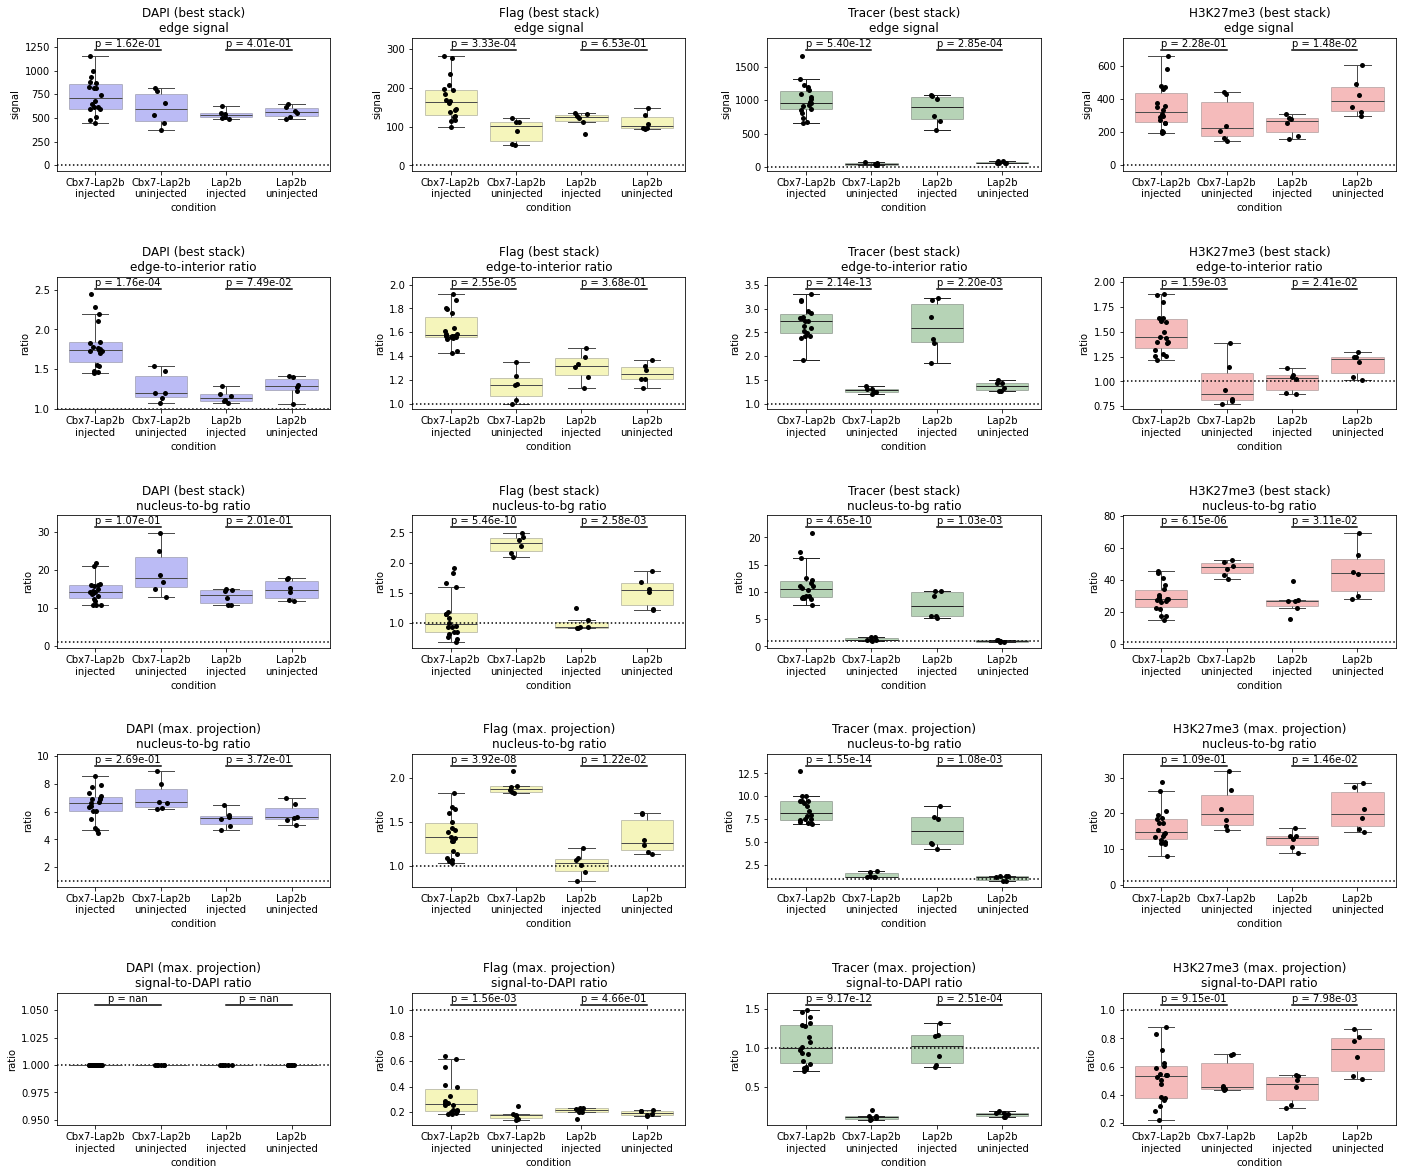

In [10]:
plot_signal_statistics('Cbx7Lap2b_H3K27me3')

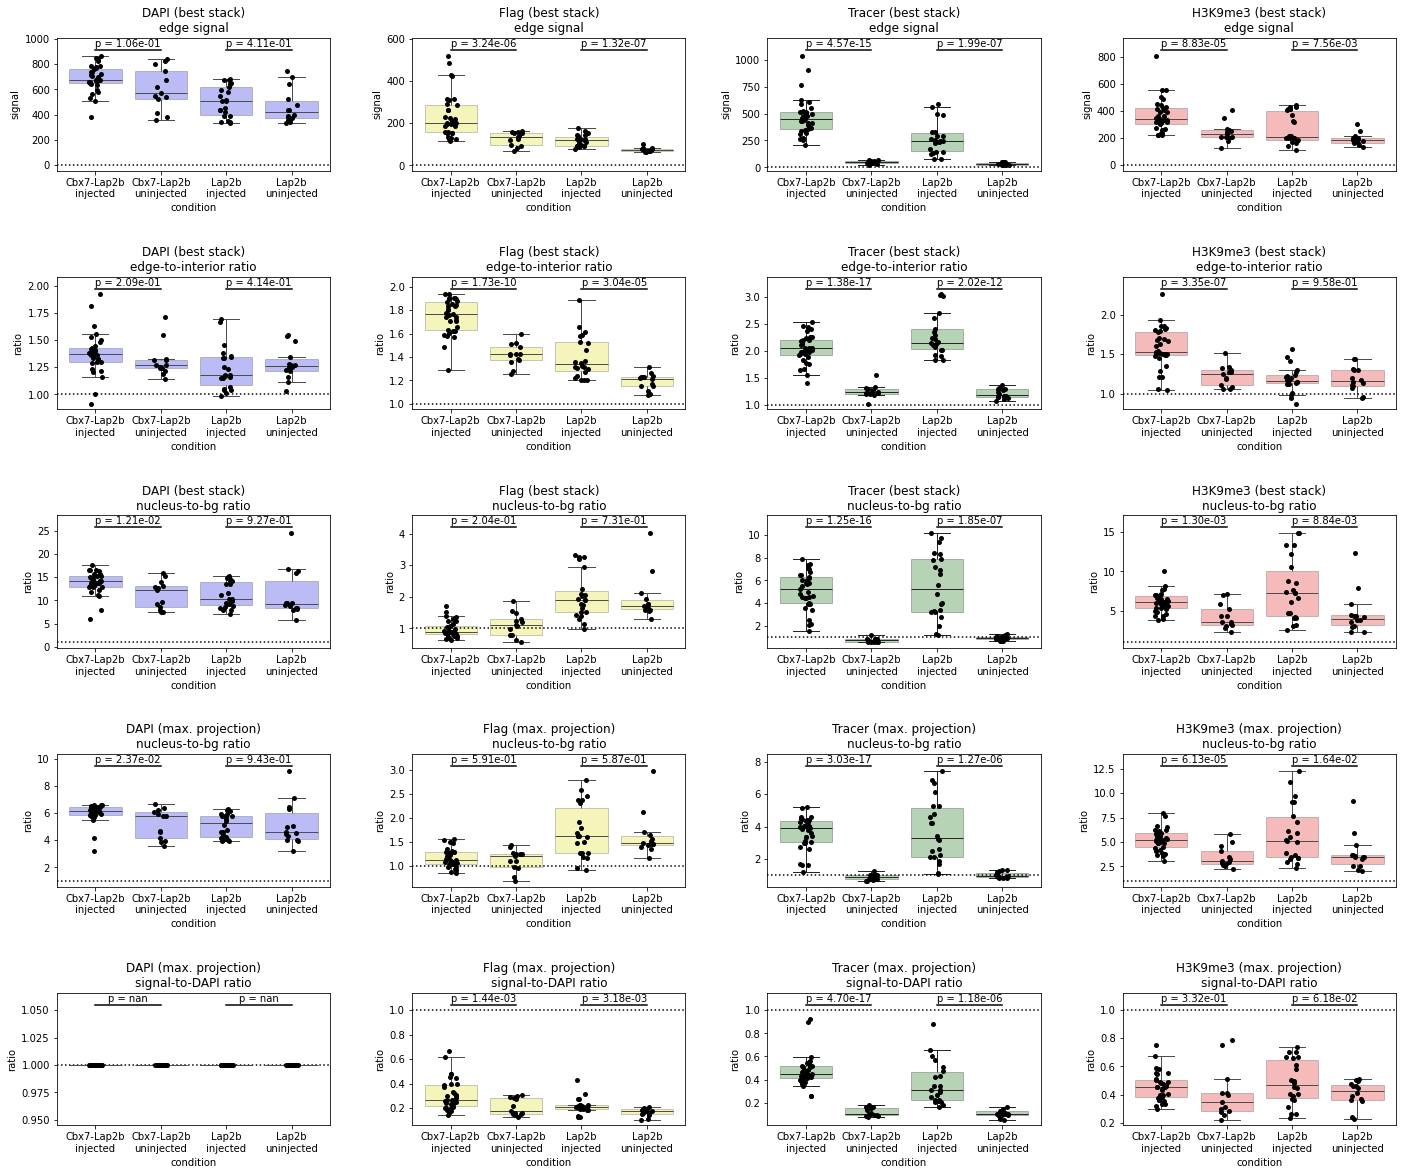

In [11]:
plot_signal_statistics('Cbx7Lap2b_H3K9me3')

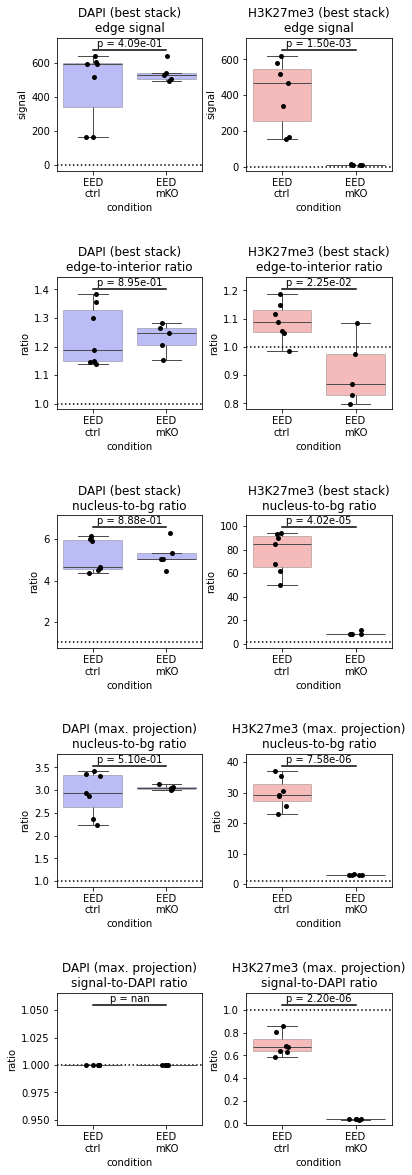

In [12]:
plot_signal_statistics('EEDmKO_H3K27me3')

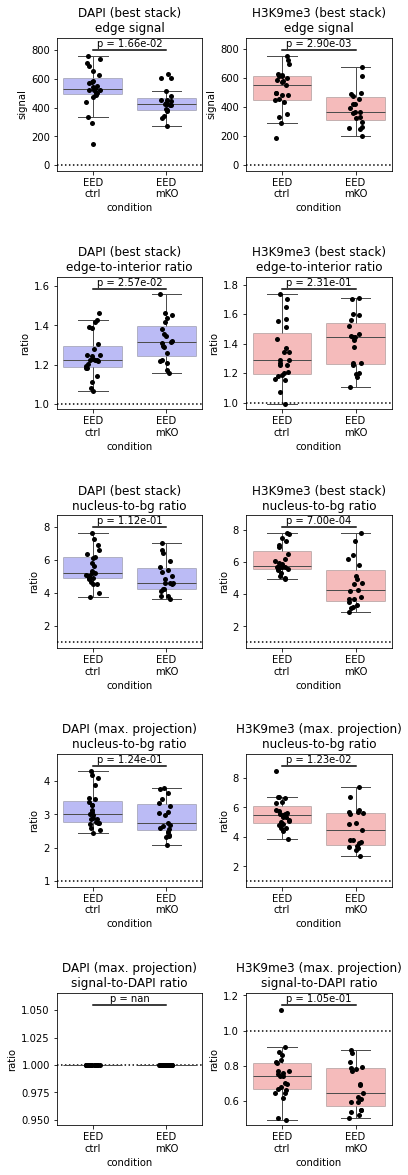

In [13]:
plot_signal_statistics('EEDmKO_H3K9me3')

## Function to plot individual image statistics

In [14]:
def plot_image_stats(ds, channel, feature1, feature2, max_projection, split_slides, sharey=False):
    np.random.seed(1)
    channel_ls = channel_info[ds]['name'].values
    n_conditions = len(sample_info[ds]['condition'].unique())
    clrdict = {'DAPI': 'blue', 'Tracer': 'limegreen', 'Flag': 'goldenrod', 'H3K9me3': 'red', 'H3K27me3': 'red'}

    to_plot = sample_info[ds].copy()
    to_plot['sample_name'] = to_plot.apply(axis = 1, func = lambda r: '%s_%s' % (r['condition'], r['embryo_id']))
    if not max_projection:
        # generate plotting DF for best stack
        tmp = stack_data[ds].copy()
        tmp = tmp[tmp.is_best_stack]
        to_plot = to_plot.merge(tmp)

    else:
        tmp = mp_data[ds].copy()
        to_plot = to_plot.merge(tmp)

    to_plot['ratio'] = to_plot['%s.%s_mean' % (channel, feature1)] / to_plot['%s.%s_mean' % (channel, feature2)]
    ratio_name = '%s-vs-%s' % (feature1, feature2)
    if not split_slides:
        to_plot['slide'] = 'all_slides'

    ncol = len(to_plot['slide'].unique())
    figw = len(to_plot['condition'].unique())
    figw = figw*1.2 if ncol>1 else figw
    fig, axes = plt.subplots(1,ncol, figsize=(figw, 2), sharey=sharey)
    plt.subplots_adjust(wspace=.4)
    counter = 0
    
    stat_ls = list()

    for slide, slidedf in to_plot.groupby('slide'):

        ax = axes if ncol==1 else axes[counter]
        counter += 1

        ax.set_title('%s\n%s' % (channel,slide))
        order = slidedf['condition'].sort_values().unique()

        sns.boxplot(
            x=slidedf['condition'], y=slidedf['ratio'], 
            order=order, fliersize=0, ax=ax, color='white', linecolor='k'
        )
        sns.swarmplot(
            x=slidedf['condition'], y=slidedf['ratio'], 
            order=order, color=clrdict[channel], ax=ax
        )
        ax.set_ylabel(ratio_name)
        ax.set_xticks(ax.get_xticks())
        xticklabs = ['%s\n(n=%d)' % (cond, (slidedf.condition==cond).sum()) for cond in order]
        ax.set_xticklabels(xticklabs, rotation=90)

        ylim = ax.get_ylim()
        ymx = ylim[1]
        yrange = ylim[1] - ylim[0]
        ax.set_ylim(ylim[0], ymx + 0.15*yrange)
        
        for conds in conditions_to_compare[ds]:
            if (conds[0] not in order) or (conds[1] not in order):
                continue
            x1, x2 = np.arange(len(slidedf['condition'].unique()))[np.isin(order, conds)]

            R = slidedf['ratio']
            A = R[slidedf.condition == conds[0]]
            B = R[slidedf.condition == conds[1]]
#             s, p = stats.mannwhitneyu(A, B)
            s, p = stats.ttest_ind(A, B, equal_var=False)

            y = ymx + 0.01 * yrange 
            ax.plot([x1, x2], [ymx, ymx], c='k')
            ax.text(np.mean([x1,x2]), y, 'p = %.2e' % p, ha='center', va='bottom')
            
            stat_ls.append([ds, channel, ratio_name, conds[0], conds[1], len(A),  len(B), np.mean(A), np.mean(B), np.std(A), np.std(B), p])
    stat_df = pd.DataFrame(stat_ls, columns=['dataset', 'channel', 'feature', 'condition1', 'condition2', 'n1', 'n2', 'mean1', 'mean2', 'std1', 'std2', 'Ttest_pval'])
    return stat_df

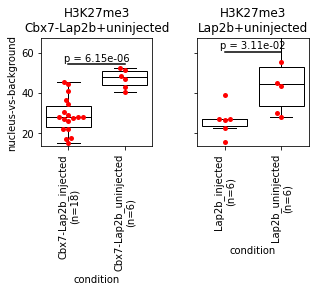

In [15]:
ds = 'Cbx7Lap2b_H3K27me3'
channel = 'H3K27me3'
feature1 = 'nucleus'
feature2 = 'background'
max_projection = False
split_slides = True

stat_df = plot_image_stats(ds, channel, feature1, feature2, max_projection, split_slides, sharey=True)
 

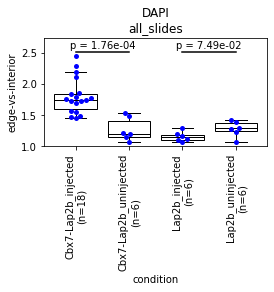

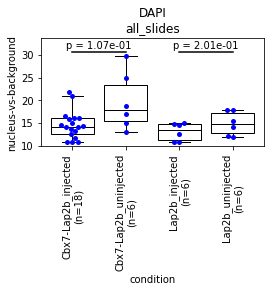

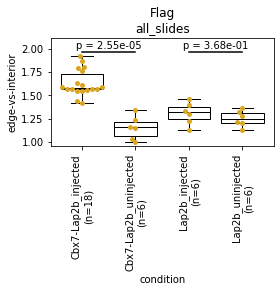

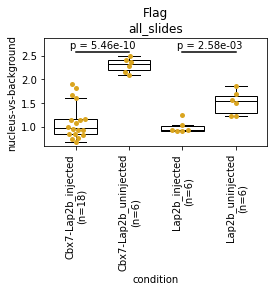

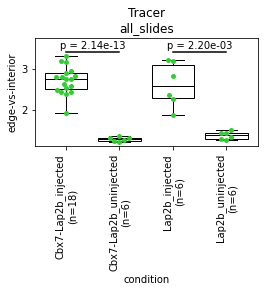

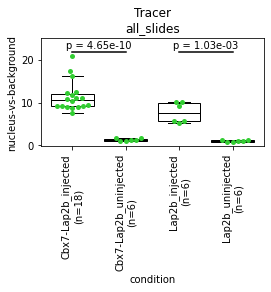

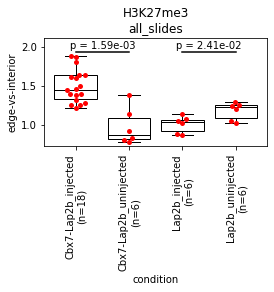

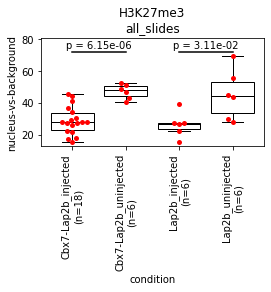

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


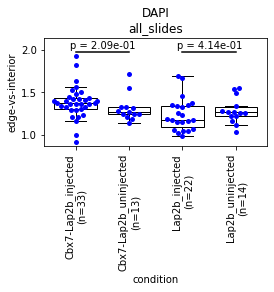

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


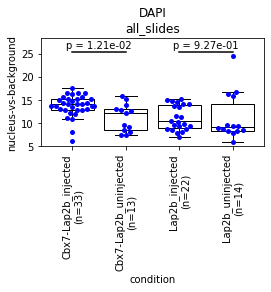

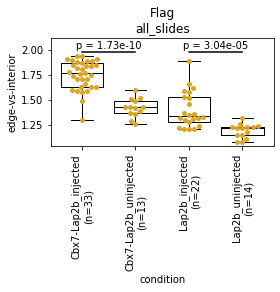

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


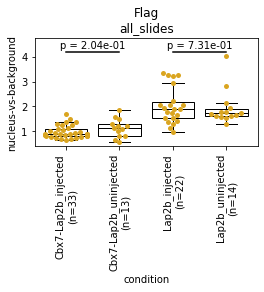

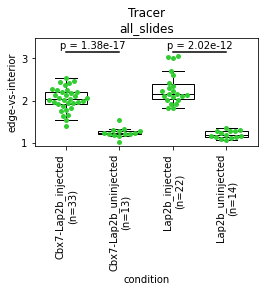

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 23.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 14.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 21.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


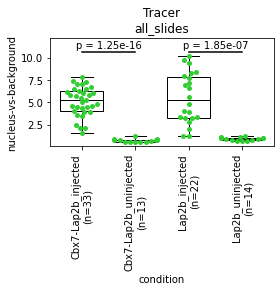

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


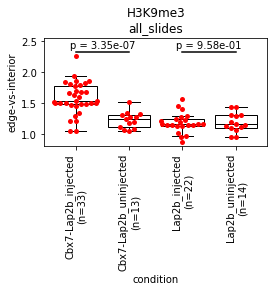

/Users/f.rang/.venvs/preimplantation/lib/python3.8/site-packages/seaborn/categorical.py:3370: UserWarning: 6.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


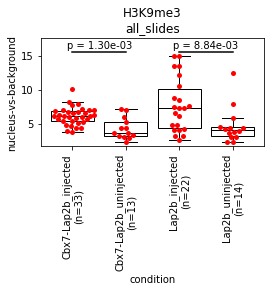

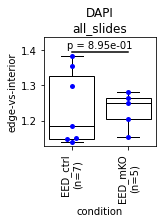

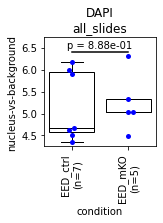

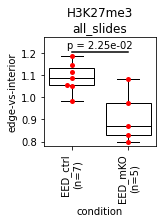

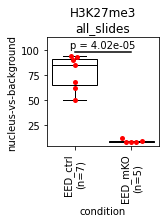

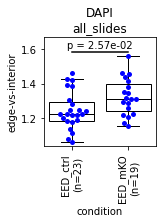

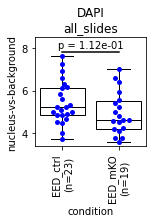

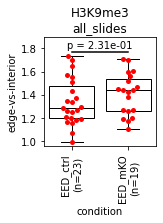

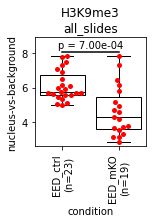

In [16]:
stat_ls = list()
outfnfmt = FIGOUTDIR + '{ds}.{channel}.{f1}_vs_{f2}.best_stack_per_nucleus.pdf'

for ds in datasets.keys():
    split_slides = False #not ds.startswith('EED')
    for channel in channel_info[ds]['name']:
        for f1, f2 in [('edge', 'interior'), ('nucleus', 'background')]:
            stat_df = plot_image_stats(ds, channel, f1, f2, max_projection=False, split_slides=split_slides, sharey=True)
            stat_ls.append(stat_df)
            
            outfn = outfnfmt.format(ds=ds, channel=channel, f1=f1, f2=f2)
            plt.savefig(outfn, bbox_inches='tight')
            plt.show()
            plt.close()

In [17]:
stat_df = pd.concat(stat_ls, axis=0).reset_index(drop=True)
outfn = FIGOUTDIR + 'all_statistical_test_results.tsv.gz'
stat_df.to_csv(outfn, sep='\t', header=True, index=False)

## Plot radial signal

In [18]:
def plot_radial_signal(ds, multiple_stacks=False):
    # generate plotting DF for best stack
    plot_all = sample_info[ds].copy()
    plot_all['sample_name'] = plot_all.apply(axis = 1, func = lambda r: '%s_%s' % (r['condition'], r['embryo_id']))
    tmp = ring_data[ds].copy()
    if multiple_stacks:
        tmp2 = tmp.loc[tmp.is_best_stack, ['sample_name', 'nucleus_area']].copy().rename(columns={'nucleus_area': 'area_best'})
        tmp = tmp.merge(tmp2)
        select_ind = tmp['nucleus_area'] > (tmp['area_best']*0.9)
        tmp = tmp[select_ind].drop(columns=['area_best'])
        cols = tmp.filter(regex='nucleus_|ring_').columns.values
        cols = ['sample_name', 'nucleus', 'ring'] + list(cols)
        tmp = tmp[cols].groupby(['sample_name', 'nucleus', 'ring']).mean().reset_index()
    else:
        tmp = tmp[tmp.is_best_stack]
    plot_all = plot_all.merge(tmp)

    channels = channel_info[ds].loc[channel_info[ds]['name'] != 'Flag','name'].values

    nrow = len(plot_all['condition'].unique())
    ncol = len(channels)
    fig, axes = plt.subplots(nrow, ncol, figsize=(ncol*5, nrow*3))
    plt.subplots_adjust(hspace=.6, wspace=.4)
    counter = 0 

    clrdict = {'DAPI': 'b', 'Tracer': 'g', 'H3K9me3': 'r', 'H3K27me3': 'r'}

    for condition, df in plot_all.groupby('condition'):

        for icol, channel in enumerate(channels):

            ax = axes[counter,icol]
            ax.set_title('%s - %s' % (condition, channel), color=clrdict[channel])

            for info, df_eid in df.groupby(['embryo_id', 'nucleus']):

                X = df_eid['ring'].values
                Y = df_eid['%s.ring_mean' % channel].values
                m = df_eid['%s.nucleus_mean' % channel].values
                ax.plot(X, Y/m, label=info)

    #         sns.boxplot(x=df['ring'], y=df['%s.ring_mean' % channel]/df['%s.nucleus_mean' % channel], color='white', ax=ax)
            xticks = np.arange(0,df['ring'].max()+1,2)
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticks*0.5)
            ax.set_xlabel('distance from nuclear edge [micron]')
            ax.set_ylabel('relative signal')

    #         ax.legend()

        counter += 1

    for icol in range(ncol):
        yrange = np.array([ax.get_ylim() for ax in axes[:,icol]])
        ymin = yrange.min(axis=0)[0]
        ymax = yrange.max(axis=0)[1]
        for ax in axes[:,icol]:
            ax.set_ylim(ymin,ymax)

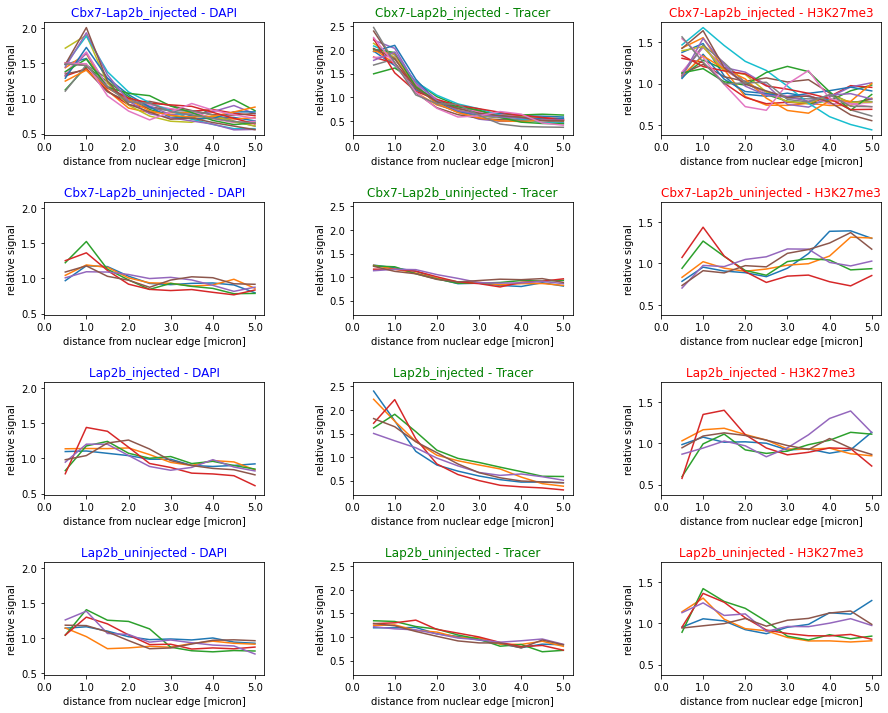

In [19]:
plot_radial_signal('Cbx7Lap2b_H3K27me3')

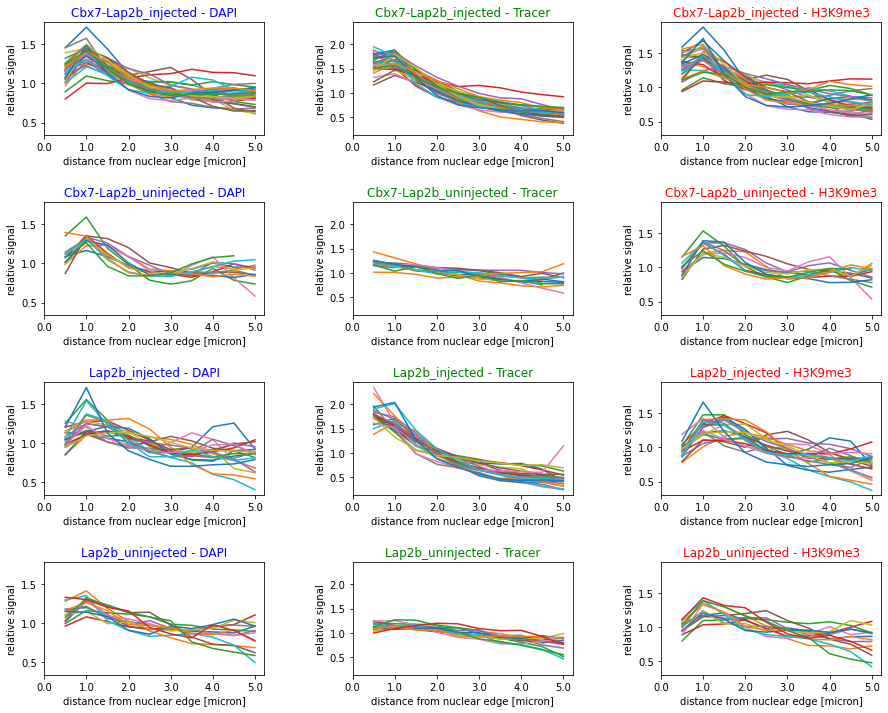

In [20]:
plot_radial_signal('Cbx7Lap2b_H3K9me3')

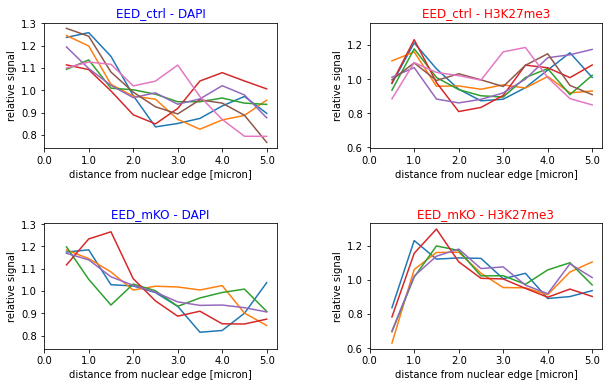

In [21]:
plot_radial_signal('EEDmKO_H3K27me3')

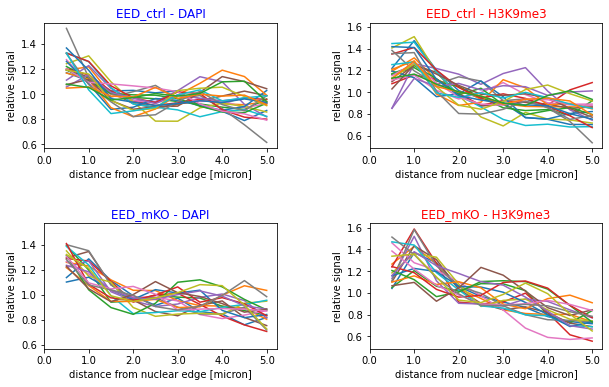

In [22]:
plot_radial_signal('EEDmKO_H3K9me3')

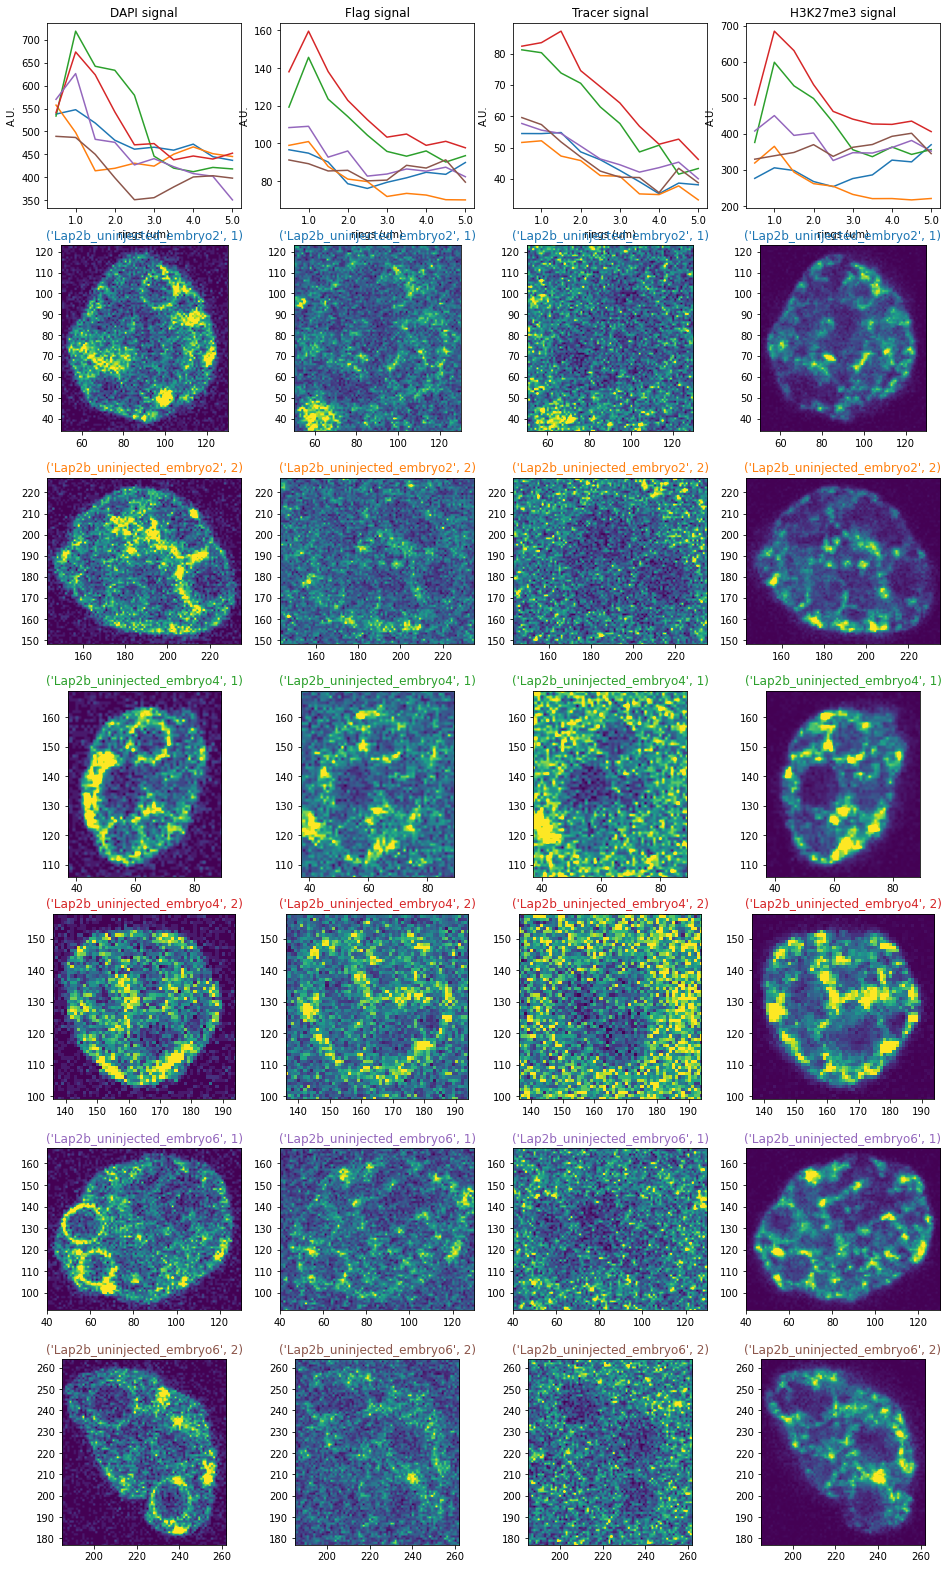

In [23]:
ds = 'Cbx7Lap2b_H3K27me3'
condition = 'Lap2b_uninjected'
samples = sample_info[ds].loc[sample_info[ds]['condition']==condition,'sample_name'].values
to_plot = ring_data[ds].copy()
to_plot = to_plot[to_plot.is_best_stack]
to_plot = to_plot[to_plot.sample_name.isin(samples)]

nrow = (to_plot['ring'] == 1).sum() + 1
ncol = len(channel_info[ds])
fig, axes = plt.subplots(nrow, ncol, figsize=(4*ncol, 4*nrow))

clrdict = {info: sns.color_palette('tab10',n_colors=10)[i] for i, (info, _) in enumerate(to_plot.groupby(['sample_name', 'nucleus']))}

for icol, channel in enumerate(channel_info[ds]['name'].values):
    
    r_counter = 1
    
    ax0 = axes[0,icol]
    ax0.set_title('%s signal' % channel)
    ax0.set_ylabel('A.U.')
    ax0.set_xlabel('rings (um)')
    ax0.set_xticks(np.arange(0,11,2))
    ax0.set_xticklabels(np.arange(0,11,2)/2)
    
    vmx = to_plot.loc[to_plot['ring']==1,'%s.nucleus_mean' % channel].max() * 2
    
    for info, df in to_plot.groupby(['sample_name', 'nucleus']):
        
        # collect nuclear pos
        tmp = stack_data[ds]
        ind = (tmp.sample_name == info[0]) & (tmp.nucleus == info[1]) & (tmp.is_best_stack)
        a = tmp.loc[ind,'nucleus_pos'].values[0]
        miny, minx, maxy, maxx = eval(a)
        
        # plot signal over concentric circles
        X = df['ring']
        Y = df['%s.ring_mean' % channel]
        clr = clrdict[info]
        ax0.plot(X, Y, c=clr)
        
        # plot nucleus
        ax = axes[r_counter,icol]
        r_counter += 1
        
        best_iz = int(df['zstack'].values[0])
        D = image_dict[ds][info[0]][best_iz,:,:,icol]
        ax.imshow(D, vmin=0, vmax=vmx)
        ax.set_title(info, color=clr)
        ax.set_xlim(minx-5, maxx+5)
        ax.set_ylim(miny-5, maxy+5)